In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from os import path, listdir
from scipy.signal import savgol_filter
import glob

In [37]:
def chop_filename(fn):
    _ = path.splitext(path.basename(fn))[0]
    return _[:_.find("_intensity")]

def find_peak(df : pd.DataFrame, channel="Cy3"):
    """Add a column that marks location of peak in the dataframe"""
    d = df[channel]

    df["peak"] = df[channel] > 0.5*(d.min() + d.max())
    return df


def get_edges(df : pd.DataFrame, channel="Cy3", w=0.8):
    df = find_peak(df, channel=channel)
    i = np.array(df[df.peak].index)

    # extract front edge
    a = i.min() - 2*w*i.ptp()
    b = i.min() + w*i.ptp()
    df["front"] = (df.index > a) & (df.index < b)

    # extract back edge
    a = i.max() - w*i.ptp()
    b = i.max() + 2*w*i.ptp()
    df["back"] = (df.index > a) & (df.index < b)
    return df


def where_eq(s, level, first=True):
    # find intersection points
    p = pd.Series(np.diff(np.sign(s - level)) != 0, index=s.index[:-1])
    if first:
        return p[p].index[0]
    else:
        return p[p].index[-1]


class Transition():
    def __init__(self, a, b, start, end, steady_low, steady_high, thresh_low, thresh_high):
        # Transition timings
        self._a, self._b = a, b
        self.tau = b - a

        # Analysis window
        self._start, self._end = start, end
        self.w = end - start

        # Steady states
        self.low = steady_low
        self.high = steady_high
        self.ptp = steady_high - steady_low
        self.half = steady_low + self.ptp/2

        # Thresholds
        self.t_low = thresh_low
        self.t_high = thresh_high
        self.thresh_diff = thresh_high - thresh_low

        # x-axis offset
        self.offset = 0

    @property
    def a(self):
        return self._a - self.offset

    @property
    def b(self):
        return self._b - self.offset

    @property
    def start(self):
        return self._start - self.offset

    @property
    def end(self):
        return self._end - self.offset


def analyze_transition(smooth_edge : pd.Series, margin=0.1):
    # Find midpoint
    x0 = where_eq(smooth_edge, 0.5*(smooth_edge.min()+smooth_edge.max()))

    # split into left and right
    left = smooth_edge.loc[:x0]
    right = smooth_edge.loc[x0:]

    # steady state levels
    ls = left.median()
    rs = right.median()

    up = ls < rs

    m = margin*abs(ls - rs)

    #   front edge        back edge
    lt = ls + m if up else ls - m
    rt = rs - m if up else rs + m

    t = Transition(
        a = where_eq(left, lt, first=False),
        b = where_eq(right, rt, first=True),
        start = smooth_edge.index.min(),
        end = smooth_edge.index.max(),
        steady_low = min(ls, rs),
        steady_high = max(ls, rs),
        thresh_low = min(lt, rt),
        thresh_high = max(lt, rt),
    )
    return t


def show_dataset(df, channel, front, back, ax, offset=0):
    d = get_edges(df, channel)

    if offset:
        d.index -= offset
        front.offset = offset
        back.offset = offset

    ax.plot(d[channel], '.-', c='grey', alpha=0.2)
    ax.plot(d[channel+"s"], 'k-', lw=0.5)

    def show_transition(t, c="gray", ha="left"):
        ax.add_patch(plt.Rectangle((t.start, t.low), t.w, t.ptp, lw=0.5, fc="none", ec=c, alpha=0.5))
        ax.add_patch(plt.Rectangle((t.a, t.t_low), t.tau, t.thresh_diff, lw=0.5, fc="none", ec="k"))
        ax.text(t.a + t.tau/2, t.t_high + 0.01*t.ptp, f"{t.tau:.0f} ms", ha="center")

    show_transition(front, "darkgreen", ha="right")
    show_transition(back, "navy", ha="left")
    ax.set_xlabel("Time / ms")
    ax.set_ylabel("Photon count")


def analyze_csv(fn):
    df = pd.read_csv(fn, index_col='time')
    # First frame is usually garbage, drop it
    df = df.iloc[1:]

    # convert s to ms
    df.index *= 1000

    return analyze_df(df)

def analyze_df(df):
    # What channel contains the strongest signal?

    channel = df.filter(regex=("Cy?")).apply(np.ptp, axis=0).idxmax()

    # Find front and back edges
    df = get_edges(df, channel=channel)

    # Smooth signal with savgol_filter. Window length is proportional to peak FWHM
    window_length = 2*(len(df[df.peak])//10) + 1
    df[channel+"s"] = savgol_filter(df[channel], window_length, 3)

    # Analyze front and back transitions
    front = analyze_transition(df.Cy3s[df.front])
    back = analyze_transition(df.Cy3s[df.back])
    return df, channel, front, back

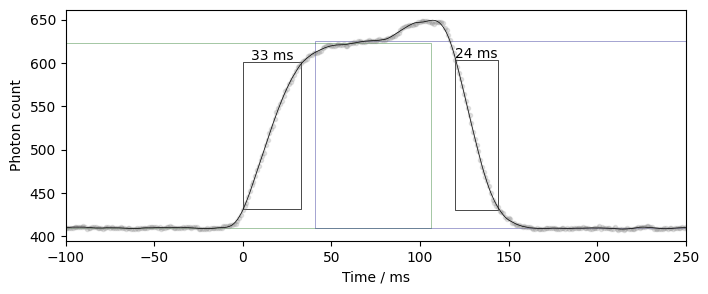

In [38]:
ax = plt.figure(figsize=(8,3)).gca()
df, channel, front, back = analyze_csv(r"sm_particle_counter/test/data/intensity/test_027_intensity.csv")

show_dataset(df, channel, front, back, ax, offset=front.a)
plt.xlim(-100, 250);

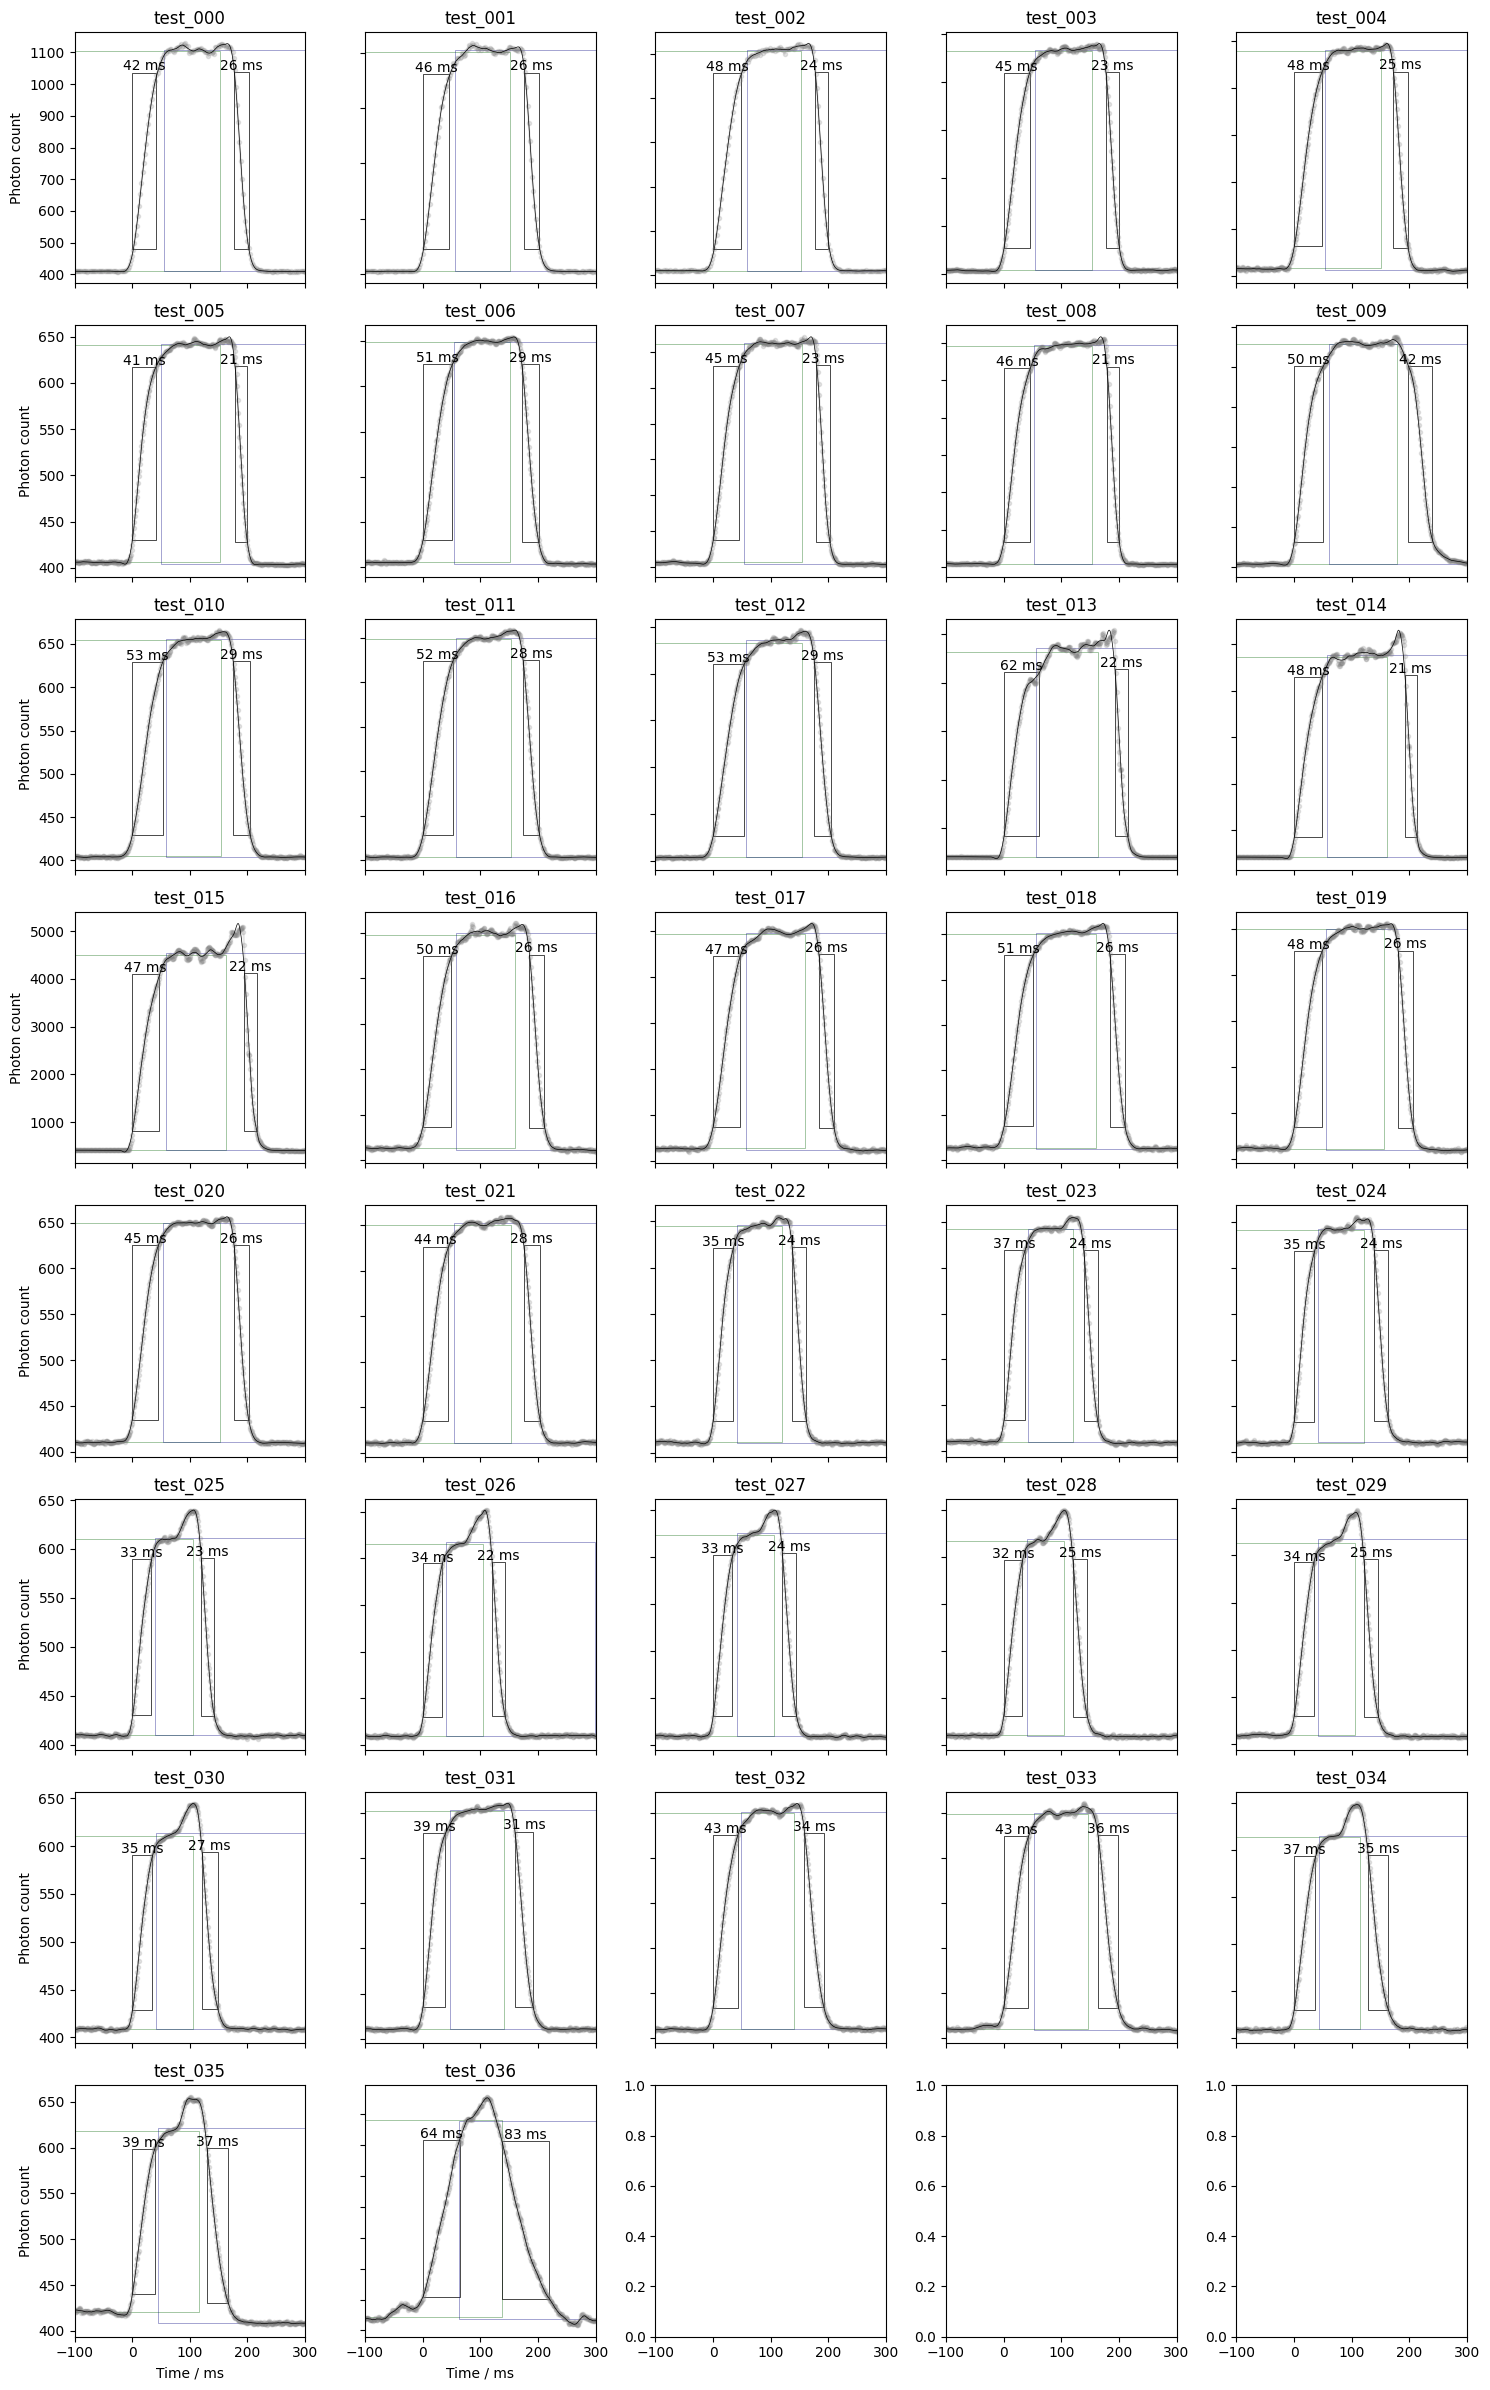

In [40]:
dir = r"sm_particle_counter/test/data/intensity"
files = glob.glob(path.join(dir, "*_intensity.csv"))

N = len(files)
ncol = 5
nrow = (N-1) // ncol + 1
fig, axs = plt.subplots(nrow, ncol, figsize=(15,3*nrow), sharey=False, sharex=True)

timings = []
for i in range(N):
    col = i % ncol
    row = i // ncol
    fn = files[i]

    df, channel, front, back = analyze_csv(fn)
    timings.append(dict(fn=chop_filename(fn), front=front.tau, back=back.tau, amplitude=front.ptp))

    ax = axs[row, col]

    show_dataset(df, channel, front, back, ax, front.a)

    ax.set_title(chop_filename(fn))
    ax.label_outer()

ax.set_xlim(-100, 300);
plt.tight_layout()
plt.savefig("rise_time_analysis_aligned.pdf")

In [4]:
pd.DataFrame.from_dict(timings).to_csv("sm_particle_counter/test/data/timings.csv", sep="\t", float_format="%g")

# Individual plots

In [41]:
# Save individual images with aligned x-axis
for i in range(N):
    ax = plt.figure(figsize=(7,4)).gca()

    fn = files[i]
    df, channel, front, back = analyze_csv(fn)

    show_dataset(df, channel, front, back, ax, offset=front.a)

    plt.title(chop_filename(fn))
    plt.xlim(-100, 300)
    outfile = path.splitext(fn)[0] + ".png"
    plt.savefig(outfile, dpi=300)
    plt.close();